# Section 2: Analyzing Causal Forests on Simulated Data similar to GSS data 

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML
from tqdm.auto import tqdm

from copy import deepcopy
import joblib
import warnings
import joblib
import math
warnings.filterwarnings("ignore")

def fullDisplay():
    pd.set_option("display.max_rows", None, "display.max_columns", None)

def defaultDisplay():
    pd.reset_option('^display.', silent=True)

## Loading data

In [2]:
welfare = pd.read_csv("Data/welfare_clean.csv", low_memory=False)
treatments = welfare['w']
labels = welfare['y']
welfare.drop(columns=['w', 'y'], inplace=True)
welfare

,year,id,wrkstat,hrs1,hrs2,evwork,occ,prestige,wrkslf,wrkgovt,...,adults_miss,unrelat_miss,earnrs_miss,income_miss,rincome_miss,income86_miss,partyid_miss,polviews_miss,attblack,attblack_miss
0,0,1,7,0.004845,0.005228,1,135,0.005641,2,2,...,0,0,0,0,0,0,0,0,0.005440,0
1,0,2,1,0.005055,0.005228,0,106,0.006538,2,2,...,0,1,0,0,1,0,0,0,0.004080,0
2,0,3,7,0.004845,0.005228,1,99,0.006538,2,2,...,0,1,0,0,0,0,0,0,0.002040,0
3,0,4,3,0.005055,0.005228,0,142,0.004615,2,0,...,0,0,0,0,1,0,0,0,0.004080,0
4,0,5,8,0.005055,0.005228,1,211,0.005171,2,1,...,0,0,0,0,0,0,0,0,0.004080,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36496,15,2040,3,0.005055,0.005228,0,211,0.005171,2,2,...,0,0,0,0,1,1,0,0,0.004080,0
36497,15,2041,3,0.005055,0.005228,0,211,0.005171,2,2,...,0,0,0,0,1,1,0,0,0.006120,0
36498,15,2042,7,0.004845,0.005228,1,211,0.005171,2,2,...,0,1,0,0,0,1,0,0,0.004080,0
36499,15,2043,7,0.005935,0.005228,1,211,0.005171,2,2,...,0,1,0,0,1,1,0,0,0.005021,1


## DGP, Estimation, and Evaluation functions

In [29]:
def dgp(welfare, effect_type="heterogeneous", effect_homogeneous=10, effect_heterogeneous=2,
        treatment_type="binary", treatment_probability=0.5, heterogeneous_select=4, overlap=True,
        overlap_percent=0.5, order=3, linearity="med", N=5000, treatment_cutoff_val=0.0, 
        compute_cate=False, cate_feature="race", nBins=5):    
    
    featureNames = list(welfare.columns)

    # Define non-confounders
    importantFeatureNames = ['wrkstat', 'race', 'year', 'hrs1', 'income', 'occ80', 'id', 'educ'] # top 8 important features based on Shapley visualization from 
    importantFeatureIndices = []
    for name in importantFeatureNames:
        importantFeatureIndices.append(featureNames.index(name)) 

    # Error terms
    error = np.random.normal(size=(N,1))

    # Data generation
    cov = welfare.cov()
    means = welfare.mean(axis=0)
    X = np.random.multivariate_normal(means.values, cov, size=N, check_valid='warn', tol=1e-8)
    
    # Linearity specification
    if linearity != 'full':
        select = 0 # select n most important features for interactions and polynomials
        poly = PolynomialFeatures(degree=order, interaction_only=False, include_bias=False)

        if linearity == "high": 
            select = 2
        elif linearity == "med": 
            select = 4
        elif linearity == "low": 
            select = 8
        else: # if some typo, assume baseline of high
            select = 2

        # Interaction term calculation for outcome Y
        poly.fit(X[:, importantFeatureIndices[:select]])
        fullData = poly.transform(X[:, importantFeatureIndices[:select]])
        fullNames = poly.get_feature_names(input_features=importantFeatureNames[:select])
        higherData = fullData[:, -(fullData.shape[1] - select):] # select only higher order
        higherNames = fullNames[-(len(fullNames) - select):]

        X = np.append(X, higherData, axis=1) 
        featureNames.extend(list(higherNames))

    # Treatment selection
    if treatment_type == "binary":
        # randomly assigned treatments with propensity treatment_probability
        treatments = np.random.choice([0, 1], size=N, p=[1 - treatment_probability, treatment_probability]).reshape((-1, 1))
        if not overlap:
            forced = random.sample(list(np.arange(treatments.shape[0])), int(treatments.shape[0] * overlap_percent))
            treatments[forced] = 0
        treated = treatments > 0

        # generate counterfactual treatment indicator vector
        c_treatments = deepcopy(treatments)
        c_treatments[treatments == 0] = 1
        c_treatments[treatments == 1] = 0
    else:
        low = 0
        high = 1
        treatments = np.random.uniform(low, high, size=(N, 1))
        if not overlap:
            forced = random.sample(list(np.arange(treatments.shape[0])), int(treatments.shape[0] * overlap_percent))
            treatments[forced] = 0
        
        # set all treatment values close to 0 to 0
        for idx, val in enumerate(treatments):
            if math.isclose(val, 0, abs_tol=0.5):
                treatments[idx] = 0

        treated = treatments > treatment_cutoff_val

        # to-do: counterfactual treatment vector
        c_treatments = deepcopy(treatments)
        c_treatments[treatments > treatment_cutoff_val] = 0
        c_treatments[treatments == 0] = (low + high)/2 # treatments.mean() # set to mean treatment value
        

    # Treatment effect calculation
    if effect_type == "homogeneous":

        T = treatments*effect_homogeneous
        CT = c_treatments*effect_homogeneous

    else: 
        # Interaction term calculation for HTE
        poly = PolynomialFeatures(degree=order, interaction_only=False, include_bias=False)
        poly.fit(X[:, importantFeatureIndices[:heterogeneous_select]])
        fullData = poly.transform(X[:, importantFeatureIndices[:heterogeneous_select]])
        higherData = fullData[:, -(fullData.shape[1] - heterogeneous_select):] # select only higher order

        # HTE = 1 + effect * (sum of first heterogeneous_select important variables + higher order interactions of heterogeneous_select important variables)
        heterogeneousIndices = importantFeatureIndices[:heterogeneous_select]

        T = 1 + (effect_heterogeneous*(X[:, heterogeneousIndices].sum(axis=1) + higherData.sum(axis=1)))*treatments.ravel()
        T = T.reshape(-1, 1)
        T[~treated] = np.zeros((~treated).sum())
        
        # counterfactual effect
        CT = 1 + (effect_heterogeneous*(X[:, heterogeneousIndices].sum(axis=1) + higherData.sum(axis=1)))*c_treatments.ravel()
        CT = CT.reshape(-1, 1)
        CT[treated] = np.zeros((treated).sum()) # everyone that was treated goes to untreated in counterfactual

    # Coefficients calculation
    betas = np.random.normal(size=X.shape[1]).reshape(-1,1)
    # draw from diff distribution for "important" features
    if_coef_mean = 7 # important features mean 
    if_coef_var = 1 # ... var
    betas[importantFeatureIndices] = np.random.normal(if_coef_mean, if_coef_var, size=len(importantFeatureIndices)).reshape(-1, 1)

    # ATE calculation
    
    # Outcome calculation
    y = T + X@betas + error
    cy = CT + X@betas + error
    
    empirical_treated = y[treated] - cy[treated] # the treated (in y)
    empirical_untreated = cy[~treated] - y[~treated] # the untreated
    ate = (empirical_treated.mean() + empirical_untreated.mean())/2

    # CATE calculation
    if compute_cate:
        if cate_feature == 'race':
            cateCol = importantFeatureIndices[1] # index of 'race' covariate
        else:
            cateCol = importantFeatureIndices[7] # index of 'educ' covariate
        
        # Creating the bins
        evenGroups = np.array_split(np.sort(X[:, cateCol]), nBins)
        bins = []
        pdX = pd.DataFrame(X)
        pdX[cateCol]

        prevCeil = -10000
        for i in range(nBins):
            floor = evenGroups[i][0] 
            ceil = evenGroups[i][-1]
            if floor == prevCeil: # in case the floor of current group is equal to ceiling of last group, don't want to duplicate samples
                bins.append(pdX.loc[(floor < pdX[cateCol]) & (pdX[cateCol] <= ceil)].to_numpy())
            else:
                bins.append(pdX.loc[(floor <= pdX[cateCol]) & (pdX[cateCol] <= ceil)].to_numpy())
            prevCeil = ceil
        
        cates = []
        for i in range(nBins):
            indices = [] # indices to grab from y and cy
            for j in range(bins[i].shape[0]):
                indices.append(np.where((X == bins[i][j]).all(axis=1))[0][0])
            
            yBin = y[indices]
            cyBin = cy[indices]
            treatedBin = treated[indices]
            empirical_treated_bin = yBin[treatedBin] - cyBin[treatedBin] # the treated (in y)
            empirical_untreated_bin = cyBin[~treatedBin] - yBin[~treatedBin] # the untreated
            cates.append((empirical_treated_bin.mean() + empirical_untreated_bin.mean())/2)

        return y, X, betas, featureNames, treatments, cy, ate, treated, bins, cates
    else:
        return y, X, betas, featureNames, treatments, cy, ate, treated
    

def estimate_cf(y, X, treatments, treated, cy, test_size=0.2, criterion='het', cv=5, discrete_treatment=True, n_estimators=1000):
    if test_size == 0:
        X_train = X
        Y_train = y
        T_train = treatments
        X_test, Y_test, treated_test, CY_test = None, None, None, None
    # split data into train and test sets
    else:
        X_train, X_test, Y_train, Y_test, T_train, T_test, _, treated_test, _, CY_test = train_test_split(X, y, treatments, treated, cy, test_size=test_size)
        
    # specify hyperparams of model
    est = CausalForestDML(criterion=criterion, 
                            n_estimators=n_estimators,       
                            max_samples=0.5,
                            discrete_treatment=discrete_treatment,
                            honest=True,
                            inference=True,
                            cv=cv)
    # fit model
    est.fit(Y_train, T_train, X=X_train, W=None)
        
    return est, X_test, Y_test, treated_test, CY_test

In [4]:
# compute evaluation stats over K simulations
def evalStats(estimators, trueATES, evalSets):
    K = len(estimators)

    lbs = np.zeros(K)
    ubs = np.zeros(K)
    ates = np.zeros(K)
    
    totalBias = 0
    totalRMSE = 0
    totalCoverage = 0
    totalInterval = 0

    for i in range(K):
        estimateATE = estimators[i].ate(evalSets[i])[0]
        lb, ub = estimators[i].ate_interval(evalSets[i], alpha=0.05)
        lbs[i] = lb
        ubs[i] = ub
        ates[i] = estimateATE
        
        bias = abs(trueATES[i] - estimateATE)
        totalBias += bias
        
        rmse = bias**2
        totalRMSE += rmse

        coverage = 1 if (trueATES[i] >= lb and trueATES[i] <= ub) else 0
  
        totalCoverage += coverage

        interval = ub - lb
        totalInterval += interval
    
    return totalBias / K, (totalRMSE / K)**0.5, totalCoverage / K, totalInterval / K, lbs, ubs, ates

## Evaluating ATEs under different DGP settings

### (1) Sample Size

In [94]:
K = 30
Ns = [1000, 5000, 10000]

biasNs = np.zeros(len(Ns))
rmseNs = np.zeros(len(Ns))
coverageNs = np.zeros(len(Ns))
intervalNs = np.zeros(len(Ns))
lbsNs = np.zeros((len(Ns), K))
ubsNs = np.zeros((len(Ns), K))
atesNs = np.zeros((len(Ns), K))
true_atesNs = np.zeros((len(Ns), K))

for idx, N in enumerate(Ns):
    estNs = []
    trueATENs = []
    evalSetNs = []
    for i in tqdm(range(K)):
        y, X, trueBetas, featureNames, treatments, cy, ate, treated = dgp(welfare, N=N)
        
        est, X_test, Y_test, treated_test, CY_test = estimate_cf(y, X, treatments, treated, cy)

        # Calculate test set ATE
        tmp = Y_test[treated_test] - CY_test[treated_test]
        tmp1 = CY_test[~treated_test] - Y_test[~treated_test]
        test_ate = (tmp.mean() + tmp1.mean())/2
        ate = test_ate
        
        estNs.append(est)
        trueATENs.append(ate)
        evalSetNs.append(X_test)

    bias, rmse, coverage, interval, lbs, ubs, ates = evalStats(estNs, trueATENs, evalSetNs)
    
    biasNs[idx] = bias
    rmseNs[idx] = rmse
    coverageNs[idx] = coverage
    intervalNs[idx] = interval
    lbsNs[idx, :] = lbs
    ubsNs[idx, :] = ubs
    atesNs[idx, :] = ates
    true_atesNs[idx, :] = trueATENs

In [95]:
joblib.dump(biasNs, 'Results/biasNs_{}.pkl'.format(K))
joblib.dump(rmseNs, 'Results/rmseNs_{}.pkl'.format(K))
joblib.dump(coverageNs, 'Results/coverageNs_{}.pkl'.format(K))
joblib.dump(intervalNs, 'Results/intervalNs_{}.pkl'.format(K))
joblib.dump(lbsNs, 'Results/lbsNs_{}.pkl'.format(K))
joblib.dump(ubsNs, 'Results/ubsNs_{}.pkl'.format(K))
joblib.dump(atesNs, 'Results/atesNs_{}.pkl'.format(K))
joblib.dump(true_atesNs, 'Results/true_atesNs_{}.pkl'.format(K))

['Results/true_atesNs_30.pkl']

In [141]:

biasNs = joblib.load('Results/biasNs_{}.pkl'.format(K))
rmseNs = joblib.load('Results/rmseNs_{}.pkl'.format(K))
coverageNs = joblib.load('Results/coverageNs_{}.pkl'.format(K))
intervalNs = joblib.load('Results/intervalNs_{}.pkl'.format(K))
lbsNs = joblib.load('Results/lbsNs_{}.pkl'.format(K))
ubsNs = joblib.load('Results/ubsNs_{}.pkl'.format(K))
atesNs = joblib.load('Results/atesNs_{}.pkl'.format(K))
true_atesNs = joblib.load('Results/true_atesNs_{}.pkl'.format(K))

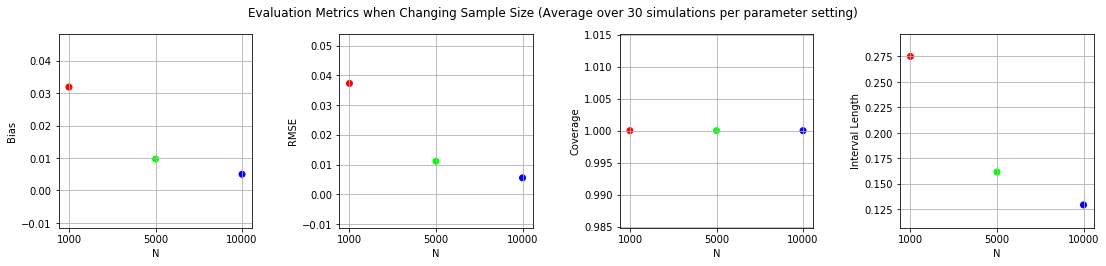

In [116]:
biasNsNorm = []
rmseNsNorm = []
intervalNsNorm = []
true_atesNsMean = []
atesNsMean = []

for idx, _ in enumerate(Ns):
    atesNsMean.append(np.mean(atesNs[idx, :]))
    true_atesNsMean.append(np.mean(true_atesNs[idx, :]))
    biasNsNorm.append(biasNs[idx] / true_atesNsMean[idx])
    rmseNsNorm.append(rmseNs[idx] / true_atesNsMean[idx])
    intervalNsNorm.append(intervalNs[idx] / true_atesNsMean[idx])

xNs = list(map(str, Ns))
cNs = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

axs[0].scatter(xNs, biasNsNorm, c=cNs/255)
axs[0].set(xlabel='N', ylabel='Bias')
axs[0].grid()
axs[1].scatter(xNs, rmseNsNorm, c=cNs/255)
axs[1].set(xlabel='N', ylabel='RMSE')
axs[1].grid()
axs[2].scatter(xNs, coverageNs, c=cNs/255)
axs[2].set(xlabel='N', ylabel='Coverage')
axs[2].grid()
axs[3].scatter(xNs, intervalNsNorm, c=cNs/255)
axs[3].set(xlabel='N', ylabel='Interval Length')
axs[3].grid()

fig.suptitle('Evaluation Metrics when Changing Sample Size (Average over ' + str(K) + ' simulations per parameter setting)')
fig.tight_layout(pad=3.0)
plt.show()

In [117]:
data = {'True ATES':true_atesNsMean, 'Estimated ATES': atesNsMean,   
        'Normalized Bias': biasNsNorm, 'Unnormalized Bias':biasNs, 
        'Normalized RMSE': rmseNsNorm, 'Unnormalized RMSE':rmseNs, 
        'Normalized Interval Length': intervalNsNorm, 'Unnormalized Interval Length':intervalNs,
        'Coverage':coverageNs}
        
tableNs = pd.DataFrame(data=data, index=xNs)
tableNs

,True ATES,Estimated ATES,Normalized Bias,Unnormalized Bias,Normalized RMSE,Unnormalized RMSE,Normalized Interval Length,Unnormalized Interval Length,Coverage
1000,5439.607849,5284.487310,0.031899,173.520082,0.037262,202.689775,0.275060,1496.219129,1.0
5000,5480.217592,5428.476930,0.009698,53.144836,0.011122,60.950723,0.161594,885.568983,1.0
10000,5464.342620,5437.754914,0.005008,27.367210,0.005541,30.277228,0.129341,706.760847,1.0


### (2) Degree of Non-linearity in X

In [96]:
K = 30
linearityLevels = ['full', 'high', 'med', 'low']

biasLLs = np.zeros(len(linearityLevels))
rmseLLs = np.zeros(len(linearityLevels))
coverageLLs = np.zeros(len(linearityLevels))
intervalLLs = np.zeros(len(linearityLevels))
lbsLLs = np.zeros((len(linearityLevels), K))
ubsLLs = np.zeros((len(linearityLevels), K))
atesLLs = np.zeros((len(linearityLevels), K))
true_atesLLs = np.zeros((len(linearityLevels), K))


for idx, level in enumerate(linearityLevels):
    estLLs = []
    trueATELLs = []
    evalSetLLs = []
    for i in tqdm(range(K)):
        y, X, trueBetas, featureNames, treatments, cy, ate, treated = dgp(welfare, linearity=level)
        est, X_test, Y_test, treated_test, CY_test = estimate_cf(y, X, treatments, treated, cy)

        # Calculate test set ATE
        tmp = Y_test[treated_test] - CY_test[treated_test]
        tmp1 = CY_test[~treated_test] - Y_test[~treated_test]
        test_ate = (tmp.mean() + tmp1.mean())/2
        ate = test_ate
        
        estLLs.append(est)
        trueATELLs.append(ate)
        evalSetLLs.append(X_test)

    bias, rmse, coverage, interval, lbs, ubs, ates = evalStats(estLLs, trueATELLs, evalSetLLs)
    
    biasLLs[idx] = bias
    rmseLLs[idx] = rmse
    coverageLLs[idx] = coverage
    intervalLLs[idx] = interval
    lbsLLs[idx, :] = lbs
    ubsLLs[idx, :] = ubs
    atesLLs[idx, :] = ates
    true_atesLLs[idx, :] = trueATELLs

In [97]:
# dump data
joblib.dump(biasLLs, 'Results/biasLLs_{}.pkl'.format(K))
joblib.dump(rmseLLs, 'Results/rmseLLs_{}.pkl'.format(K))
joblib.dump(coverageLLs, 'Results/coverageLLs_{}.pkl'.format(K))
joblib.dump(intervalLLs, 'Results/intervalLLs_{}.pkl'.format(K))
joblib.dump(lbsLLs, 'Results/lbsLLs_{}.pkl'.format(K))
joblib.dump(ubsLLs, 'Results/ubsLLs_{}.pkl'.format(K))
joblib.dump(atesLLs, 'Results/atesLLs_{}.pkl'.format(K))
joblib.dump(true_atesLLs, 'Results/true_atesLLs_{}.pkl'.format(K))

['Results/true_atesLLs_30.pkl']

In [20]:
# load data
biasLLs = joblib.load('Results/biasLLs_{}.pkl'.format(K))
rmseLLs = joblib.load('Results/rmseLLs_{}.pkl'.format(K))
coverageLLs = joblib.load('Results/coverageLLs_{}.pkl'.format(K))
intervalLLs = joblib.load('Results/intervalLLs_{}.pkl'.format(K))
lbsLLs = joblib.load('Results/lbsLLs_{}.pkl'.format(K))
ubsLLs = joblib.load('Results/ubsLLs_{}.pkl'.format(K))
atesLLs = joblib.load('Results/atesLLs_{}.pkl'.format(K))
true_atesLLs = joblib.load('Results/true_atesLLs_{}.pkl'.format(K))

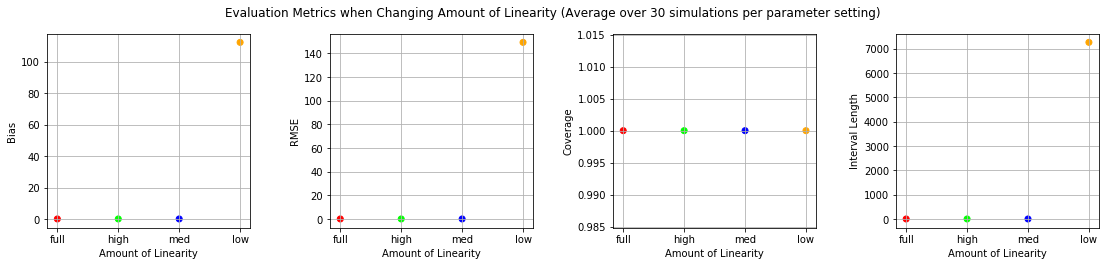

In [118]:
biasLLsNorm = []
rmseLLsNorm = []
intervalLLsNorm = []
true_atesLLsMean = []
atesLLsMean = []

for idx, _ in enumerate(linearityLevels):
    atesLLsMean.append(np.mean(atesLLs[idx, :]))
    true_atesLLsMean.append(np.mean(true_atesLLs[idx, :]))
    biasLLsNorm.append(biasLLs[idx] / true_atesLLsMean[idx])
    rmseLLsNorm.append(rmseLLs[idx] / true_atesLLsMean[idx])
    intervalLLsNorm.append(intervalLLs[idx] / true_atesLLsMean[idx])

xLLs = linearityLevels
cLLs = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 165, 0]])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

axs[0].scatter(xLLs, biasLLsNorm, c=cLLs/255)
axs[0].set(xlabel='Amount of Linearity', ylabel='Bias')
axs[0].grid()
axs[1].scatter(xLLs, rmseLLsNorm, c=cLLs/255)
axs[1].set(xlabel='Amount of Linearity', ylabel='RMSE')
axs[1].grid()
axs[2].scatter(xLLs, coverageLLs, c=cLLs/255)
axs[2].set(xlabel='Amount of Linearity', ylabel='Coverage')
axs[2].grid()
axs[3].scatter(xLLs, intervalLLsNorm, c=cLLs/255)
axs[3].set(xlabel='Amount of Linearity', ylabel='Interval Length')
axs[3].grid()

fig.suptitle('Evaluation Metrics when Changing Amount of Linearity (Average over ' + str(K) + ' simulations per parameter setting)')
fig.tight_layout(pad=3.0)
plt.show()

In [119]:
data = {'True ATES':true_atesLLsMean, 'Estimated ATES': atesLLsMean,   
        'Normalized Bias': biasLLsNorm, 'Unnormalized Bias':biasLLs, 
        'Normalized RMSE': rmseLLsNorm, 'Unnormalized RMSE':rmseLLs, 
        'Normalized Interval Length': intervalLLsNorm, 'Unnormalized Interval Length':intervalLLs,
        'Coverage':coverageLLs}
        
tableLLs = pd.DataFrame(data=data, index=xLLs)
tableLLs

,True ATES,Estimated ATES,Normalized Bias,Unnormalized Bias,Normalized RMSE,Unnormalized RMSE,Normalized Interval Length,Unnormalized Interval Length,Coverage
full,5468.773915,5440.039188,0.006647,36.353349,0.008375,45.801340,0.248466,1.358807e+03,1.0
high,5453.578001,5417.485903,0.007022,38.292994,0.008750,47.719423,0.236397,1.289210e+03,1.0
med,5535.015621,5489.769929,0.008287,45.867383,0.010120,56.011837,0.160939,8.908016e+02,1.0
low,5455.065609,11248.379766,112.262704,612400.414644,149.134321,813537.503514,7255.772887,3.958072e+07,1.0


### (3) Percentage Treated

In [98]:
K = 30
percentTreats = [0.1, 0.5, 0.9]

biasPTs = np.zeros(len(percentTreats))
rmsePTs = np.zeros(len(percentTreats))
coveragePTs = np.zeros(len(percentTreats))
intervalPTs = np.zeros(len(percentTreats))
lbsPTs = np.zeros((len(percentTreats), K))
ubsPTs = np.zeros((len(percentTreats), K))
atesPTs = np.zeros((len(percentTreats), K))
true_atesPTs = np.zeros((len(percentTreats), K))

for idx, percent in enumerate(percentTreats):
    estPTs = []
    trueATEPTs = []
    evalSetPTs = []
    for i in tqdm(range(K)):
        y, X, trueBetas, featureNames, treatments, cy, ate, treated = dgp(welfare, treatment_probability=percent)
        est, X_test, Y_test, treated_test, CY_test = estimate_cf(y, X, treatments, treated, cy)

        # Calculate test set ATE
        tmp = Y_test[treated_test] - CY_test[treated_test]
        tmp1 = CY_test[~treated_test] - Y_test[~treated_test]
        test_ate = (tmp.mean() + tmp1.mean())/2
        ate = test_ate

        estPTs.append(est)
        trueATEPTs.append(ate)
        evalSetPTs.append(X_test)

    bias, rmse, coverage, interval, lbs, ubs, ates = evalStats(estPTs, trueATEPTs, evalSetPTs)
    
    biasPTs[idx] = bias
    rmsePTs[idx] = rmse
    coveragePTs[idx] = coverage
    intervalPTs[idx] = interval
    lbsPTs[idx, :] = lbs
    ubsPTs[idx, :] = ubs
    atesPTs[idx, :] = ates
    true_atesPTs[idx, :] = trueATEPTs

In [99]:
joblib.dump(biasPTs, 'Results/biasPTs_{}.pkl'.format(K))
joblib.dump(rmsePTs, 'Results/rmsePTs_{}.pkl'.format(K))
joblib.dump(coveragePTs, 'Results/coveragePTs_{}.pkl'.format(K))
joblib.dump(intervalPTs, 'Results/intervalPTs_{}.pkl'.format(K))
joblib.dump(lbsPTs, 'Results/lbsPTs_{}.pkl'.format(K))
joblib.dump(ubsPTs, 'Results/ubsPTs_{}.pkl'.format(K))
joblib.dump(atesPTs, 'Results/atesPTs_{}.pkl'.format(K))
joblib.dump(true_atesPTs, 'Results/true_atesPTs_{}.pkl'.format(K))

['Results/true_atesPTs_30.pkl']

In [19]:
biasPTs = joblib.load('Results/biasPTs_{}.pkl'.format(K))
rmsePTs = joblib.load('Results/rmsePTs_{}.pkl'.format(K))
coveragePTs = joblib.load('Results/coveragePTs_{}.pkl'.format(K))
intervalPTs = joblib.load('Results/intervalPTs_{}.pkl'.format(K))
lbsPTs = joblib.load('Results/lbsPTs_{}.pkl'.format(K))
ubsPTs = joblib.load('Results/ubsPTs_{}.pkl'.format(K))
atesPTs = joblib.load('Results/atesPTs_{}.pkl'.format(K))
true_atesPTs = joblib.load('Results/true_atesPTs_{}.pkl'.format(K))

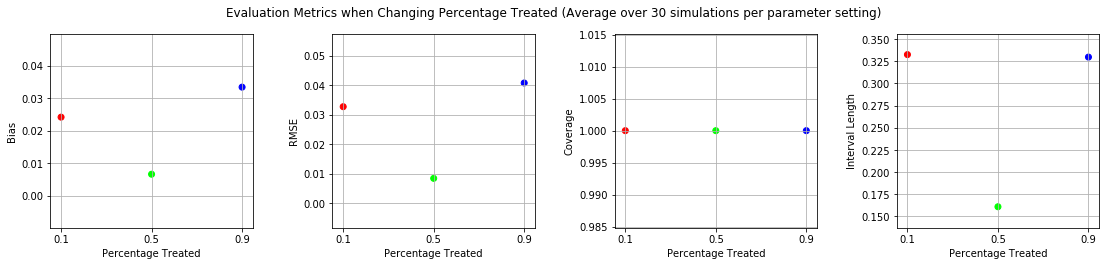

In [120]:
biasPTsNorm = []
rmsePTsNorm = []
intervalPTsNorm = []
true_atesPTsMean = []
atesPTsMean = []

for idx, _ in enumerate(percentTreats):
    atesPTsMean.append(np.mean(atesPTs[idx, :]))
    true_atesPTsMean.append(np.mean(true_atesPTs[idx, :]))
    biasPTsNorm.append(biasPTs[idx] / true_atesPTsMean[idx])
    rmsePTsNorm.append(rmsePTs[idx] / true_atesPTsMean[idx])
    intervalPTsNorm.append(intervalPTs[idx] / true_atesPTsMean[idx])

xPTs = list(map(str, percentTreats))
cPTs = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

axs[0].scatter(xPTs, biasPTsNorm, c=cPTs/255)
axs[0].set(xlabel='Percentage Treated', ylabel='Bias')
axs[0].grid()
axs[1].scatter(xPTs, rmsePTsNorm, c=cPTs/255)
axs[1].set(xlabel='Percentage Treated', ylabel='RMSE')
axs[1].grid()
axs[2].scatter(xPTs, coveragePTs, c=cPTs/255)
axs[2].set(xlabel='Percentage Treated', ylabel='Coverage')
axs[2].grid()
axs[3].scatter(xPTs, intervalPTsNorm, c=cPTs/255)
axs[3].set(xlabel='Percentage Treated', ylabel='Interval Length')
axs[3].grid()

fig.suptitle('Evaluation Metrics when Changing Percentage Treated (Average over ' + str(K) + ' simulations per parameter setting)')
fig.tight_layout(pad=3.0)
plt.show()

In [121]:
data = {'True ATES':true_atesPTsMean, 'Estimated ATES': atesPTsMean,   
        'Normalized Bias': biasPTsNorm, 'Unnormalized Bias':biasPTs, 
        'Normalized RMSE': rmsePTsNorm, 'Unnormalized RMSE':rmsePTs, 
        'Normalized Interval Length': intervalPTsNorm, 'Unnormalized Interval Length':intervalPTs,
        'Coverage':coveragePTs}
        
tablePTs = pd.DataFrame(data=data, index=xPTs)
tablePTs

,True ATES,Estimated ATES,Normalized Bias,Unnormalized Bias,Normalized RMSE,Unnormalized RMSE,Normalized Interval Length,Unnormalized Interval Length,Coverage
0.1,5490.340503,5427.326138,0.024193,132.827121,0.032698,179.524301,0.332519,1825.641746,1.0
0.5,5481.328925,5449.166690,0.006611,36.238026,0.008362,45.833821,0.160830,881.562651,1.0
0.9,5469.355627,5387.042317,0.033443,182.914155,0.040750,222.873837,0.329706,1803.281973,1.0


### (4) Overlap

In [100]:
K = 30
overlapTypes = [True, False]

biasOTs = np.zeros(len(overlapTypes))
rmseOTs = np.zeros(len(overlapTypes))
coverageOTs = np.zeros(len(overlapTypes))
intervalOTs = np.zeros(len(overlapTypes))
lbsOTs = np.zeros((len(overlapTypes), K))
ubsOTs = np.zeros((len(overlapTypes), K))
atesOTs = np.zeros((len(overlapTypes), K))
true_atesOTs = np.zeros((len(overlapTypes), K))

for idx, overlap in enumerate(overlapTypes):
    estOTs = []
    trueATEOTs = []
    evalSetOTs = []
    for i in tqdm(range(K)):
        y, X, trueBetas, featureNames, treatments, cy, ate, treated = dgp(welfare, overlap=overlap)
        est, X_test, Y_test, treated_test, CY_test = estimate_cf(y, X, treatments, treated, cy)

        # Calculate test set ATE
        tmp = Y_test[treated_test] - CY_test[treated_test]
        tmp1 = CY_test[~treated_test] - Y_test[~treated_test]
        test_ate = (tmp.mean() + tmp1.mean())/2
        ate = test_ate

        estOTs.append(est)
        trueATEOTs.append(ate)
        evalSetOTs.append(X_test)

    bias, rmse, coverage, interval, lbs, ubs, ates = evalStats(estOTs, trueATEOTs, evalSetOTs)
    
    biasOTs[idx] = bias
    rmseOTs[idx] = rmse
    coverageOTs[idx] = coverage
    intervalOTs[idx] = interval
    lbsOTs[idx, :] = lbs
    ubsOTs[idx, :] = ubs
    atesOTs[idx, :] = ates
    true_atesOTs[idx, :] = trueATEOTs

In [101]:
joblib.dump(biasOTs, 'Results/biasOTs_{}.pkl'.format(K))
joblib.dump(rmseOTs, 'Results/rmseOTs_{}.pkl'.format(K))
joblib.dump(coverageOTs, 'Results/coverageOTs_{}.pkl'.format(K))
joblib.dump(intervalOTs, 'Results/intervalOTs_{}.pkl'.format(K))
joblib.dump(lbsOTs, 'Results/lbsOTs_{}.pkl'.format(K))
joblib.dump(ubsOTs, 'Results/ubsOTs_{}.pkl'.format(K))
joblib.dump(atesOTs, 'Results/atesOTs_{}.pkl'.format(K))
joblib.dump(true_atesOTs, 'Results/true_atesOTs_{}.pkl'.format(K))

['Results/true_atesOTs_30.pkl']

In [24]:
biasOTs = joblib.load('Results/biasOTs_{}.pkl'.format(K))
rmseOTs = joblib.load('Results/rmseOTs_{}.pkl'.format(K))
coverageOTs = joblib.load('Results/coverageOTs_{}.pkl'.format(K))
intervalOTs = joblib.load('Results/intervalOTs_{}.pkl'.format(K))
lbsOTs = joblib.load('Results/lbsOTs_{}.pkl'.format(K))
ubsOTs = joblib.load('Results/ubsOTs_{}.pkl'.format(K))
atesOTs = joblib.load('Results/atesOTs_{}.pkl'.format(K))
true_atesOTs = joblib.load('Results/true_atesOTs_{}.pkl'.format(K))

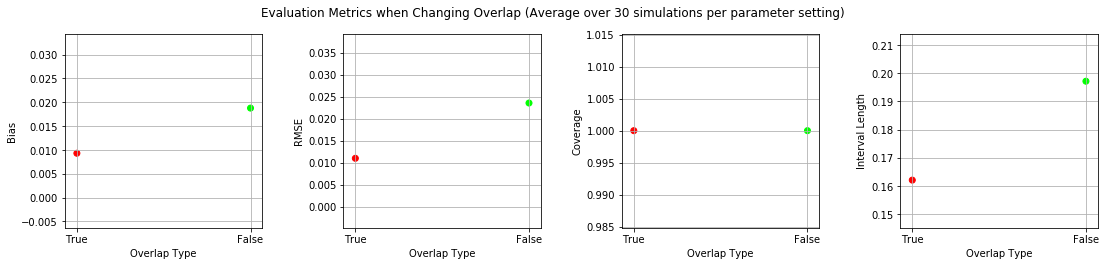

In [122]:
biasOTsNorm = []
rmseOTsNorm = []
intervalOTsNorm = []
true_atesOTsMean = []
atesOTsMean = []

for idx, _ in enumerate(overlapTypes):
    atesOTsMean.append(np.mean(atesOTs[idx, :]))
    true_atesOTsMean.append(np.mean(true_atesOTs[idx, :]))
    biasOTsNorm.append(biasOTs[idx] / true_atesOTsMean[idx])
    rmseOTsNorm.append(rmseOTs[idx] / true_atesOTsMean[idx])
    intervalOTsNorm.append(intervalOTs[idx] / true_atesOTsMean[idx])

xOTs = list(map(str, overlapTypes))
cOTs = np.array([[255, 0, 0], [0, 255, 0]])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

axs[0].scatter(xOTs, biasOTsNorm, c=cOTs/255)
axs[0].set(xlabel='Overlap Type', ylabel='Bias')
axs[0].grid()
axs[1].scatter(xOTs, rmseOTsNorm, c=cOTs/255)
axs[1].set(xlabel='Overlap Type', ylabel='RMSE')
axs[1].grid()
axs[2].scatter(xOTs, coverageOTs, c=cOTs/255)
axs[2].set(xlabel='Overlap Type', ylabel='Coverage')
axs[2].grid()
axs[3].scatter(xOTs, intervalOTsNorm, c=cOTs/255)
axs[3].set(xlabel='Overlap Type', ylabel='Interval Length')
axs[3].grid()

fig.suptitle('Evaluation Metrics when Changing Overlap (Average over ' + str(K) + ' simulations per parameter setting)')
fig.tight_layout(pad=3.0)
plt.show()

In [123]:
data = {'True ATES':true_atesOTsMean, 'Estimated ATES': atesOTsMean,   
        'Normalized Bias': biasOTsNorm, 'Unnormalized Bias':biasOTs, 
        'Normalized RMSE': rmseOTsNorm, 'Unnormalized RMSE':rmseOTs, 
        'Normalized Interval Length': intervalOTsNorm, 'Unnormalized Interval Length':intervalOTs,
        'Coverage':coverageOTs}
        
tableOTs = pd.DataFrame(data=data, index=xOTs)
tableOTs

,True ATES,Estimated ATES,Normalized Bias,Unnormalized Bias,Normalized RMSE,Unnormalized RMSE,Normalized Interval Length,Unnormalized Interval Length,Coverage
True,5453.466708,5403.129840,0.009294,50.684381,0.011013,60.060401,0.162081,883.900621,1.0
False,5456.466230,5404.707229,0.018772,102.429344,0.023589,128.709960,0.197191,1075.963858,1.0


### (5) Treatment Effect Heterogeneity Level

In [102]:
K = 30
heterogeneityLevels = [0, 2, 4, 8]

biasHLs = np.zeros(len(heterogeneityLevels))
rmseHLs = np.zeros(len(heterogeneityLevels))
coverageHLs = np.zeros(len(heterogeneityLevels))
intervalHLs = np.zeros(len(heterogeneityLevels))
lbsHLs = np.zeros((len(heterogeneityLevels), K))
ubsHLs = np.zeros((len(heterogeneityLevels), K))
atesHLs = np.zeros((len(heterogeneityLevels), K))
true_atesHLs = np.zeros((len(heterogeneityLevels), K))

for idx, heterogeneity in enumerate(heterogeneityLevels):
    estHLs = []
    trueATEHLs = []
    evalSetHLs = []
    for i in tqdm(range(K)):
        if heterogeneity == 0:
            y, X, trueBetas, featureNames, treatments, cy, ate, treated = dgp(welfare, effect_type='homogeneous')
        else:
            y, X, trueBetas, featureNames, treatments, cy, ate, treated = dgp(welfare, heterogeneous_select=heterogeneity)

        est, X_test, Y_test, treated_test, CY_test = estimate_cf(y, X, treatments, treated, cy)

        # Calculate test set ATE
        tmp = Y_test[treated_test] - CY_test[treated_test]
        tmp1 = CY_test[~treated_test] - Y_test[~treated_test]
        test_ate = (tmp.mean() + tmp1.mean())/2
        ate = test_ate

        estHLs.append(est)
        trueATEHLs.append(ate)
        evalSetHLs.append(X_test)

    bias, rmse, coverage, interval, lbs, ubs, ates = evalStats(estHLs, trueATEHLs, evalSetHLs)
    
    biasHLs[idx] = bias
    rmseHLs[idx] = rmse
    coverageHLs[idx] = coverage
    intervalHLs[idx] = interval
    lbsHLs[idx, :] = lbs
    ubsHLs[idx, :] = ubs
    atesHLs[idx, :] = ates
    true_atesHLs[idx, :] = trueATEHLs

In [103]:
joblib.dump(biasHLs, 'Results/biasHLs_{}.pkl'.format(K))
joblib.dump(rmseHLs, 'Results/rmseHLs_{}.pkl'.format(K))
joblib.dump(coverageHLs, 'Results/coverageHLs_{}.pkl'.format(K))
joblib.dump(intervalHLs, 'Results/intervalHLs_{}.pkl'.format(K))
joblib.dump(lbsHLs, 'Results/lbsHLs_{}.pkl'.format(K))
joblib.dump(ubsHLs, 'Results/ubsHLs_{}.pkl'.format(K))
joblib.dump(atesHLs, 'Results/atesHLs_{}.pkl'.format(K))
joblib.dump(true_atesHLs, 'Results/true_atesHLs_{}.pkl'.format(K))

['Results/true_atesHLs_30.pkl']

In [38]:
biasHLs = joblib.load('Results/biasHLs_{}.pkl'.format(K))
rmseHLs = joblib.load('Results/rmseHLs_{}.pkl'.format(K))
coverageHLs = joblib.load('Results/coverageHLs_{}.pkl'.format(K))
intervalHLs = joblib.load('Results/intervalHLs_{}.pkl'.format(K))
lbsHLs = joblib.load('Results/lbsHLs_{}.pkl'.format(K))
ubsHLs = joblib.load('Results/ubsHLs_{}.pkl'.format(K))
atesHLs = joblib.load('Results/atesHLs_{}.pkl'.format(K))
true_atesHLs = joblib.load('Results/true_atesHLs_{}.pkl'.format(K))

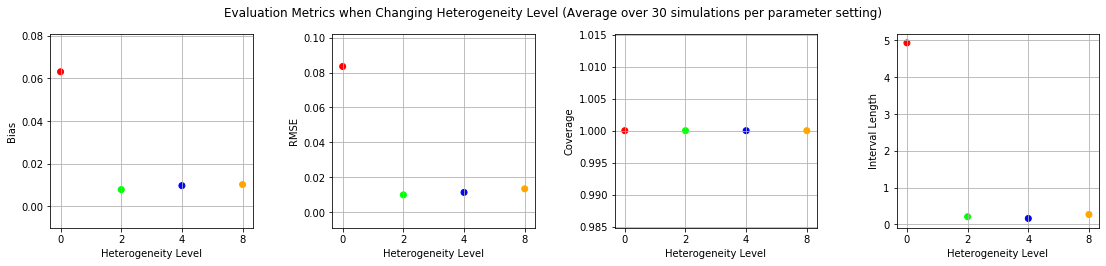

In [124]:
biasHLsNorm = []
rmseHLsNorm = []
intervalHLsNorm = []
true_atesHLsMean = []
atesHLsMean = []

for idx, _ in enumerate(heterogeneityLevels):
    atesHLsMean.append(np.mean(atesHLs[idx, :]))
    true_atesHLsMean.append(np.mean(true_atesHLs[idx, :]))
    biasHLsNorm.append(biasHLs[idx] / true_atesHLsMean[idx])
    rmseHLsNorm.append(rmseHLs[idx] / true_atesHLsMean[idx])
    intervalHLsNorm.append(intervalHLs[idx] / true_atesHLsMean[idx])

xHLs = list(map(str, heterogeneityLevels))
cHLs = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 165, 0]])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

axs[0].scatter(xHLs, biasHLsNorm, c=cHLs/255)
axs[0].set(xlabel='Heterogeneity Level', ylabel='Bias')
axs[0].grid()
axs[1].scatter(xHLs, rmseHLsNorm, c=cHLs/255)
axs[1].set(xlabel='Heterogeneity Level', ylabel='RMSE')
axs[1].grid()
axs[2].scatter(xHLs, coverageHLs, c=cHLs/255)
axs[2].set(xlabel='Heterogeneity Level', ylabel='Coverage')
axs[2].grid()
axs[3].scatter(xHLs, intervalHLsNorm, c=cHLs/255)
axs[3].set(xlabel='Heterogeneity Level', ylabel='Interval Length')
axs[3].grid()

fig.suptitle('Evaluation Metrics when Changing Heterogeneity Level (Average over ' + str(K) + ' simulations per parameter setting)')
fig.tight_layout(pad=3.0)
plt.show()

In [125]:
data = {'True ATES':true_atesHLsMean, 'Estimated ATES': atesHLsMean,   
        'Normalized Bias': biasHLsNorm, 'Unnormalized Bias':biasHLs, 
        'Normalized RMSE': rmseHLsNorm, 'Unnormalized RMSE':rmseHLs, 
        'Normalized Interval Length': intervalHLsNorm, 'Unnormalized Interval Length':intervalHLs,
        'Coverage':coverageHLs}
        
tableHLs = pd.DataFrame(data=data, index=xHLs)
tableHLs

,True ATES,Estimated ATES,Normalized Bias,Unnormalized Bias,Normalized RMSE,Unnormalized RMSE,Normalized Interval Length,Unnormalized Interval Length,Coverage
0,1.000000e+01,9.826431e+00,0.063075,6.307467e-01,0.083456,8.345605e-01,4.932942,4.932942e+01,1.0
2,7.931915e+02,7.874031e+02,0.007815,6.198745e+00,0.009976,7.912705e+00,0.207744,1.647809e+02,1.0
4,5.458236e+03,5.407529e+03,0.009657,5.270965e+01,0.011377,6.209724e+01,0.160495,8.760214e+02,1.0
8,1.262573e+10,1.256825e+10,0.010169,1.283857e+08,0.013431,1.695761e+08,0.268069,3.384565e+09,1.0


### (6) Treatment Type (Continuous vs. Discrete)

In [74]:
K = 50
treatmentTypes = ['continuous', 'binary']

biasTTs = np.zeros(len(treatmentTypes))
rmseTTs = np.zeros(len(treatmentTypes))
coverageTTs = np.zeros(len(treatmentTypes))
intervalTTs = np.zeros(len(treatmentTypes))
lbsTTs = np.zeros((len(treatmentTypes), K))
ubsTTs = np.zeros((len(treatmentTypes), K))
atesTTs = np.zeros((len(treatmentTypes), K))
true_atesTTs = np.zeros((len(treatmentTypes), K))

for idx, treatment_type in enumerate(treatmentTypes):
    estTTs = []
    trueATETTs = []
    evalSetTTs = []
    criterion = 'het' if treatment_type == "binary" else 'mse'
    discrete_treatment = True if treatment_type == "binary" else False
    for i in tqdm(range(K)):
        y, X, trueBetas, featureNames, treatments, cy, ate, treated = dgp(welfare, treatment_type=treatment_type)
        
        est, X_test, Y_test, treated_test, CY_test = estimate_cf(y, X, treatments, treated, cy, criterion=criterion, discrete_treatment=discrete_treatment)

        # Calculate test set ATE
        tmp = Y_test[treated_test] - CY_test[treated_test]
        tmp1 = CY_test[~treated_test] - Y_test[~treated_test]
        test_ate = (tmp.mean() + tmp1.mean())/2
        ate = test_ate
        estTTs.append(est)
        trueATETTs.append(ate)
        evalSetTTs.append(X_test)

    bias, rmse, coverage, interval, lbs, ubs, ates = evalStats(estTTs, trueATETTs, evalSetTTs)
    
    biasTTs[idx] = bias
    rmseTTs[idx] = rmse
    coverageTTs[idx] = coverage
    intervalTTs[idx] = interval
    lbsTTs[idx, :] = lbs
    ubsTTs[idx, :] = ubs
    atesTTs[idx, :] = ates
    true_atesTTs[idx, :] = trueATETTs

In [75]:
joblib.dump(biasTTs, 'Results/biasTTs_{}.pkl'.format(K))
joblib.dump(rmseTTs, 'Results/rmseTTs_{}.pkl'.format(K))
joblib.dump(coverageTTs, 'Results/coverageTTs_{}.pkl'.format(K))
joblib.dump(intervalTTs, 'Results/intervalTTs_{}.pkl'.format(K))
joblib.dump(lbsTTs, 'Results/lbsTTs_{}.pkl'.format(K))
joblib.dump(ubsTTs, 'Results/ubsTTs_{}.pkl'.format(K))
joblib.dump(atesTTs, 'Results/atesTTs_{}.pkl'.format(K))
joblib.dump(true_atesTTs, 'Results/true_atesTTs_{}.pkl'.format(K))

['Results/intervalTTs_50.pkl']

In [46]:
biasTTs = joblib.load('Results/biasTTs_{}.pkl'.format(K))
rmseTTs = joblib.load('Results/rmseTTs_{}.pkl'.format(K))
coverageTTs = joblib.load('Results/coverageTTs_{}.pkl'.format(K))
intervalTTs = joblib.load('Results/intervalTTs_{}.pkl'.format(K))
lbsTTs = joblib.load('Results/lbsTTs_{}.pkl'.format(K))
ubsTTs = joblib.load('Results/ubsTTs_{}.pkl'.format(K))
atesTTs = joblib.load('Results/atesTTs_{}.pkl'.format(K))
true_atesTTs = joblib.load('Results/true_atesTTs_{}'.format(K))

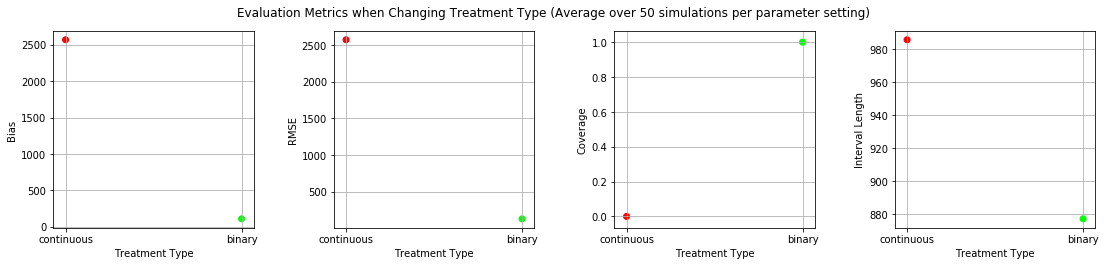

In [80]:
biasTTsNorm = []
rmseTTsNorm = []
intervalTTsNorm = []
true_atesTTsMean = []
atesTTsMean = []

for idx, _ in enumerate(treatmentTypes):
    atesTTsMean.append(np.mean(atesTTs[idx, :]))
    true_atesTTsMean.append(np.mean(true_atesTTs[idx, :]))
    biasTTsNorm.append(biasTTs[idx] / true_atesTTsMean[idx])
    rmseTTsNorm.append(rmseTTs[idx] / true_atesTTsMean[idx])
    intervalTTsNorm.append(intervalTTs[idx] / true_atesTTsMean[idx])

xTTs = treatmentTypes
cTTs = np.array([[255, 0, 0], [0, 255, 0]])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

axs[0].scatter(xTTs, biasTTsNorm, c=cTTs/255)
axs[0].set(xlabel='Treatment Type', ylabel='Bias')
axs[0].grid()
axs[1].scatter(xTTs, rmseTTsNorm, c=cTTs/255)
axs[1].set(xlabel='Treatment Type', ylabel='RMSE')
axs[1].grid()
axs[2].scatter(xTTs, coverageTTs, c=cTTs/255)
axs[2].set(xlabel='Treatment Type', ylabel='Coverage')
axs[2].grid()
axs[3].scatter(xTTs, intervalTTsNorm, c=cTTs/255)
axs[3].set(xlabel='Treatment Type', ylabel='Interval Length')
axs[3].grid()

fig.suptitle('Evaluation Metrics when Changing Treatment Type (Average over ' + str(K) + ' simulations per parameter setting)')
fig.tight_layout(pad=3.0)
plt.show()

In [81]:
data = {'True ATES':true_atesTTsMean, 'Estimated ATES': atesTTsMean,   
        'Normalized Bias': biasTTsNorm, 'Unnormalized Bias':biasTTs, 
        'Normalized RMSE': rmseTTsNorm, 'Unnormalized RMSE':rmseTTs, 
        'Normalized Interval Length': intervalTTsNorm, 'Unnormalized Interval Length':intervalTTs,
        'Coverage':coverageTTs}
        
tableTTs = pd.DataFrame(data=data, index=xTTs)
tableTTs

,Bias,RMSE,Coverage,Interval Length
continuous,2569.386936,2572.952936,0.0,985.637771
binary,107.081582,131.637333,1.0,877.233591


### (7) N_Estimators

In [104]:
K = 30
estimatorNs = [100, 500, 1000, 5000]

biasENs = np.zeros(len(estimatorNs))
rmseENs = np.zeros(len(estimatorNs))
coverageENs = np.zeros(len(estimatorNs))
intervalENs = np.zeros(len(estimatorNs))
lbsENs = np.zeros((len(estimatorNs), K))
ubsENs = np.zeros((len(estimatorNs), K))
atesENs = np.zeros((len(estimatorNs), K))
true_atesENs = np.zeros((len(estimatorNs), K))

for idx, n_estimators in enumerate(estimatorNs):
    estENs = []
    trueATEENs = []
    evalSetENs = []
    
    for i in tqdm(range(K)):
        y, X, trueBetas, featureNames, treatments, cy, ate, treated = dgp(welfare)
        
        est, X_test, Y_test, treated_test, CY_test = estimate_cf(y, X, treatments, treated, cy, n_estimators=n_estimators)

        # Calculate test set ATE
        tmp = Y_test[treated_test] - CY_test[treated_test]
        tmp1 = CY_test[~treated_test] - Y_test[~treated_test]
        test_ate = (tmp.mean() + tmp1.mean())/2
        ate = test_ate
        
        estENs.append(est)
        trueATEENs.append(ate)
        evalSetENs.append(X_test)

    bias, rmse, coverage, interval, lbs, ubs, ates = evalStats(estENs, trueATEENs, evalSetENs)
    
    biasENs[idx] = bias
    rmseENs[idx] = rmse
    coverageENs[idx] = coverage
    intervalENs[idx] = interval
    lbsENs[idx, :] = lbs
    ubsENs[idx, :] = ubs
    atesENs[idx, :] = ates
    true_atesENs[idx, :] = trueATEENs

In [105]:
joblib.dump(biasENs, 'Results/biasENs_{}.pkl'.format(K))
joblib.dump(rmseENs, 'Results/rmseENs_{}.pkl'.format(K))
joblib.dump(coverageENs, 'Results/coverageENs_{}.pkl'.format(K))
joblib.dump(intervalENs, 'Results/intervalENs_{}.pkl'.format(K))
joblib.dump(lbsENs, 'Results/lbsENs_{}.pkl'.format(K))
joblib.dump(ubsENs, 'Results/ubsENs_{}.pkl'.format(K))
joblib.dump(atesENs, 'Results/atesENs_{}.pkl'.format(K))
joblib.dump(true_atesENs, 'Results/true_atesENs_{}.pkl'.format(K))

['Results/true_atesENs_30.pkl']

In [45]:
biasENs = joblib.load('Results/biasENs_{}.pkl'.format(K))
rmseENs = joblib.load('Results/rmseENs_{}.pkl'.format(K))
coverageENs = joblib.load('Results/coverageENs_{}.pkl'.format(K))
intervalENs = joblib.load('Results/intervalENs_{}.pkl'.format(K))
lbsENs = joblib.load('Results/lbsENs_{}.pkl'.format(K))
ubsENs = joblib.load('Results/ubsENs_{}.pkl'.format(K))
atesENs = joblib.load('Results/atesENs_{}.pkl'.format(K))
true_atesENs = joblib.load('Results/true_atesENs_{}.pkl'.format(K))

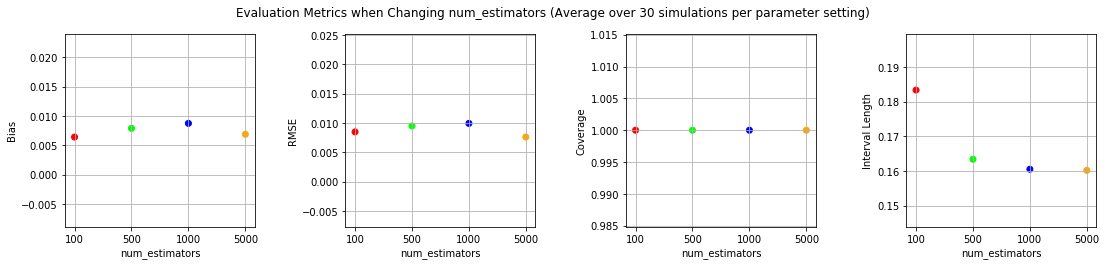

In [126]:
biasENsNorm = []
rmseENsNorm = []
intervalENsNorm = []
true_atesENsMean = []
atesENsMean = []

for idx, _ in enumerate(estimatorNs):
    atesENsMean.append(np.mean(atesENs[idx, :]))
    true_atesENsMean.append(np.mean(true_atesENs[idx, :]))
    biasENsNorm.append(biasENs[idx] / true_atesENsMean[idx])
    rmseENsNorm.append(rmseENs[idx] / true_atesENsMean[idx])
    intervalENsNorm.append(intervalENs[idx] / true_atesENsMean[idx])

xENs = list(map(str, estimatorNs))
cENs = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 165, 0]])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

axs[0].scatter(xENs, biasENsNorm, c=cENs/255)
axs[0].set(xlabel='num_estimators', ylabel='Bias')
axs[0].grid()
axs[1].scatter(xENs, rmseENsNorm, c=cENs/255)
axs[1].set(xlabel='num_estimators', ylabel='RMSE')
axs[1].grid()
axs[2].scatter(xENs, coverageENs, c=cENs/255)
axs[2].set(xlabel='num_estimators', ylabel='Coverage')
axs[2].grid()
axs[3].scatter(xENs, intervalENsNorm, c=cENs/255)
axs[3].set(xlabel='num_estimators', ylabel='Interval Length')
axs[3].grid()

fig.suptitle('Evaluation Metrics when Changing num_estimators (Average over ' + str(K) + ' simulations per parameter setting)')
fig.tight_layout(pad=3.0)
plt.show()

In [46]:
data = {'True ATES':true_atesENsMean, 'Estimated ATES': atesENsMean,   
        'Normalized Bias': biasENsNorm, 'Unnormalized Bias':biasENs, 
        'Normalized RMSE': rmseENsNorm, 'Unnormalized RMSE':rmseENs, 
        'Normalized Interval Length': intervalENsNorm, 'Unnormalized Interval Length':intervalENs,
        'Coverage':coverageENs}
        
tableENs = pd.DataFrame(data=data, index=xENs)
tableENs

,True ATES,Estimated ATES,Normalized Bias,Unnormalized Bias,Normalized RMSE,Unnormalized RMSE,Normalized Interval Length,Unnormalized Interval Length,Coverage
100,5565.936961,5532.114094,0.006077,33.822867,0.006077,33.822867,0.187268,1042.320012,1.0
500,5523.942920,5449.390716,0.013496,74.552204,0.013496,74.552204,0.150349,830.519095,1.0
1000,5474.819893,5450.791857,0.004389,24.028036,0.004389,24.028036,0.149775,819.989987,1.0
5000,5361.625270,5287.516977,0.013822,74.108293,0.013822,74.108293,0.156813,840.772017,1.0


## Evaluating CATEs for covariates responsible/not responsible for treatment effect hetereogeneity on baseline model

### Race covariate (responsible for heterogeneity)

#### Baseline DGP

In [131]:
N = 2000
nBins = 10

y, X, trueBetas, featureNames, treatments, cy, ate, treated, bins, cates = dgp(welfare, N=N, cate_feature='race', nBins=nBins, compute_cate=True)
yFit, XFit, treatmentsFit, treatedFit, cyFit = y[:N//2], X[:N//2], treatments[:N//2], treated[:N//2], cy[:N//2]

est, _, _, _, _ = estimate_cf(yFit, XFit, treatmentsFit, treatedFit, cyFit, test_size=0.0)

# filtering out the bins 
# so they don’t contain any observations we used to fit the estimator
binNumbers = np.arange(start=1, stop=1+len(bins))
filteredBins = []
for i in range(nBins):
    fBin = []
    for j in range(bins[i].shape[0]):
        if len(np.where((XFit == bins[i][j]).all(axis=1))[0]) == 0:
            fBin.append(bins[i][j])
    filteredBins.append(np.array(fBin))

cateEstimates = []
cateLBS = []
cateUBS = []
for fBin in filteredBins:
    cate = est.ate(fBin)[0]
    lb, ub = est.ate_interval(fBin, alpha=0.05)
    cateEstimates.append(cate)
    cateLBS.append(lb[0])
    cateUBS.append(ub[0])

In [132]:
biasRaces = []
biasRacesNorm = []
intervalRaces = []
intervalRacesNorm = []
coverageRaces = []

for i in range(nBins):
    bias = abs(cates[i] - cateEstimates[i])
    interval = cateUBS[i] - cateLBS[i]
    coverage = 1 if (cates[i] >= cateLBS[i] and cates[i] <= cateUBS[i]) else 0
    
    biasRaces.append(bias)
    biasRacesNorm.append(bias/cates[i])
    intervalRaces.append(interval)
    intervalRacesNorm.append(interval/cates[i])
    coverageRaces.append(coverage)

race_data = {'True CATES':cates, 'Estimated CATES':cateEstimates,   
        'Normalized Bias':biasRacesNorm, 'Unnormalized Bias':biasRaces,
        'Normalized Interval Length':intervalRacesNorm, 'Interval Length':intervalRaces, 
        'Coverage':coverageRaces}

In [133]:
joblib.dump(race_data, 'Results/race_data_{}_{}.pkl'.format(N, nBins))

['Results/race_data_2000_10.pkl']

In [82]:
race_data = joblib.load('Results/race_data_{}_{}.pkl'.format(N, nBins))

In [113]:
tableRaceCATEs = pd.DataFrame(data=race_data, index=binNumbers)
tableRaceCATEs

,True CATES,Estimated CATES,Normalized Bias,Unnormalized Bias,Normalized Interval Length,Interval Length,Coverage
1,4926.555939,5009.312198,0.016798,82.756259,0.095238,469.196415,1
2,5142.082670,5179.515633,0.007280,37.432963,0.091061,468.244818,1
3,5360.951560,5329.162879,0.005930,31.788681,0.078633,421.547511,1
4,5353.864625,5357.187781,0.000621,3.323156,0.086316,462.124527,1
5,5366.344329,5414.664407,0.009004,48.320078,0.081023,434.799978,1
6,5480.692735,5488.121219,0.001355,7.428484,0.082019,449.521619,1
7,5420.216131,5447.816893,0.005092,27.600762,0.069976,379.287211,1
8,5662.928104,5635.069118,0.004920,27.858986,0.076567,433.594357,1
9,5785.191579,5693.767873,0.015803,91.423706,0.074132,428.865523,1
10,6059.622143,5897.952609,0.026680,161.669534,0.077551,469.932142,1


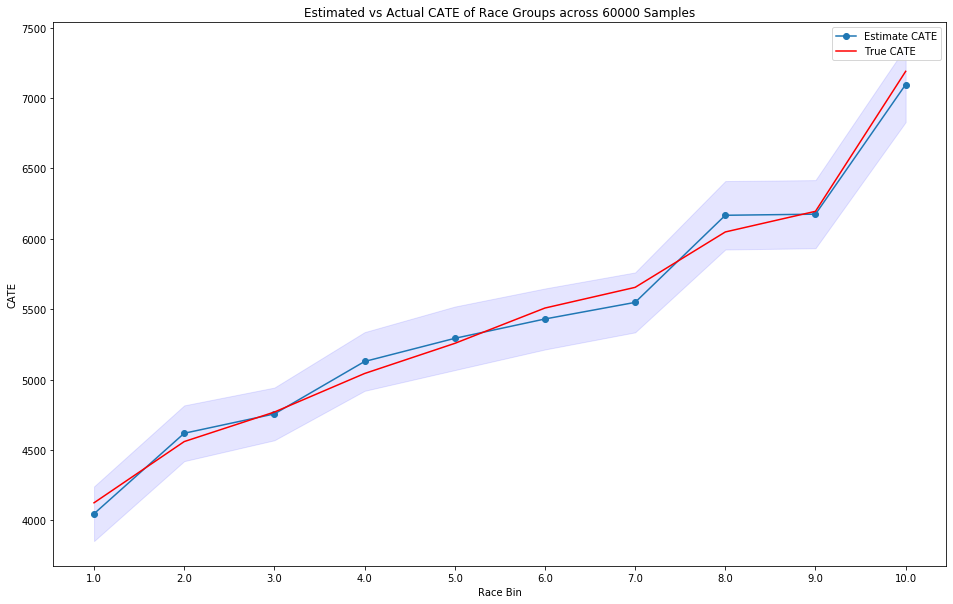

In [114]:
plt.figure(figsize=(16,10))
plt.xlabel("Race Bin")
plt.ylabel("CATE")
plt.plot(binNumbers, cateEstimates, marker='o', label="Estimate CATE")
plt.plot(binNumbers, cates, color='red', label='True CATE')
plt.title("Estimated vs Actual CATE of Race Groups across {} Samples".format(N))
plt.legend()
plt.fill_between(binNumbers, cateLBS, cateUBS, color='b', alpha=.1)
plt.xticks(np.linspace(start=1, stop=len(bins), num=len(bins)), np.linspace(start=1, stop=len(bins), num=len(bins)))
plt.show()

In [135]:
tableRaceCATEs = pd.DataFrame(data=race_data, index=binNumbers)
tableRaceCATEs

,True CATES,Estimated CATES,Normalized Bias,Unnormalized Bias,Normalized Interval Length,Interval Length,Coverage
1,4724.317252,4980.540479,0.054235,256.223226,0.289109,1365.843001,1
2,5442.992350,5449.997484,0.001287,7.005134,0.237109,1290.582805,1
3,4873.069411,5298.360401,0.087274,425.290990,0.268035,1306.151616,1
4,5145.608782,5358.996609,0.041470,213.387827,0.294324,1514.476952,1
5,5320.116680,5284.884210,0.006622,35.232470,0.263939,1404.187669,1
6,4869.680867,5053.196727,0.037685,183.515859,0.262034,1276.019939,1
7,6115.852411,5543.087949,0.093652,572.764461,0.216735,1325.520243,1
8,5503.079325,5391.194473,0.020331,111.884852,0.272437,1499.245166,1
9,5773.951940,5347.874346,0.073793,426.077593,0.239495,1382.834182,1
10,6872.920944,6058.582295,0.118485,814.338649,0.206053,1416.183932,0


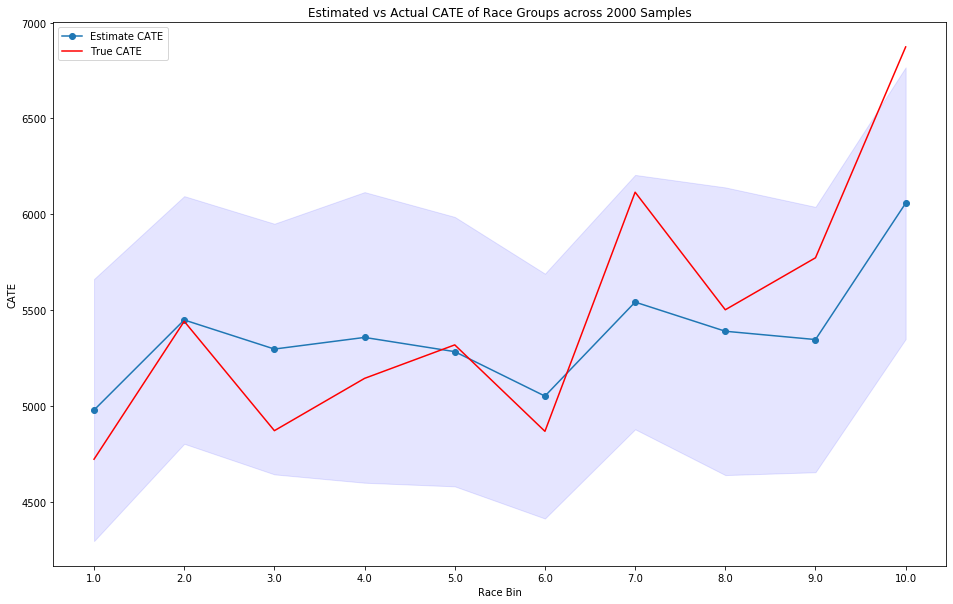

In [134]:
plt.figure(figsize=(16,10))
plt.xlabel("Race Bin")
plt.ylabel("CATE")
plt.plot(binNumbers, cateEstimates, marker='o', label="Estimate CATE")
plt.plot(binNumbers, cates, color='red', label='True CATE')
plt.title("Estimated vs Actual CATE of Race Groups across {} Samples".format(N))
plt.legend()
plt.fill_between(binNumbers, cateLBS, cateUBS, color='b', alpha=.1)
plt.xticks(np.linspace(start=1, stop=len(bins), num=len(bins)), np.linspace(start=1, stop=len(bins), num=len(bins)))
plt.show()

### Degree of treatment effect heterogeneity

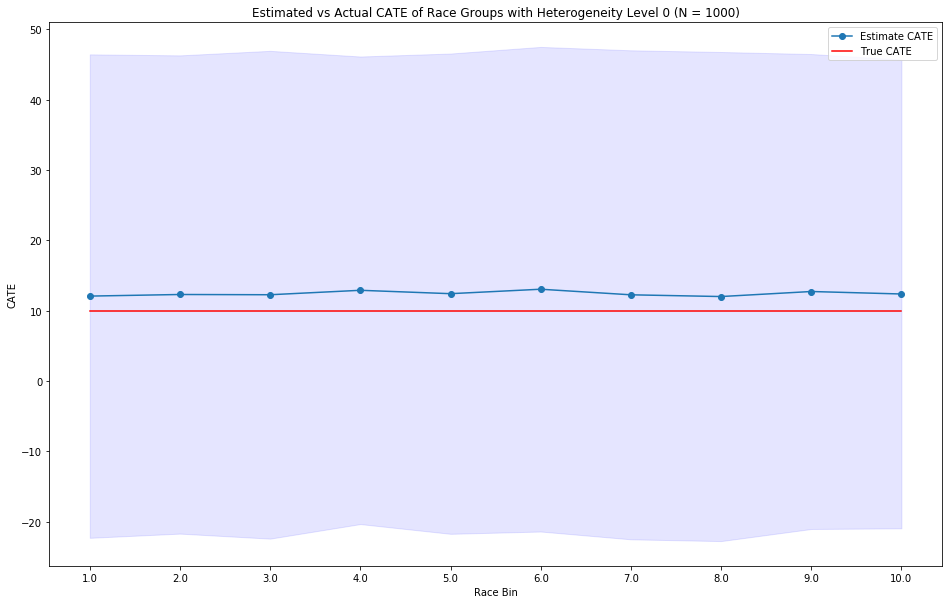

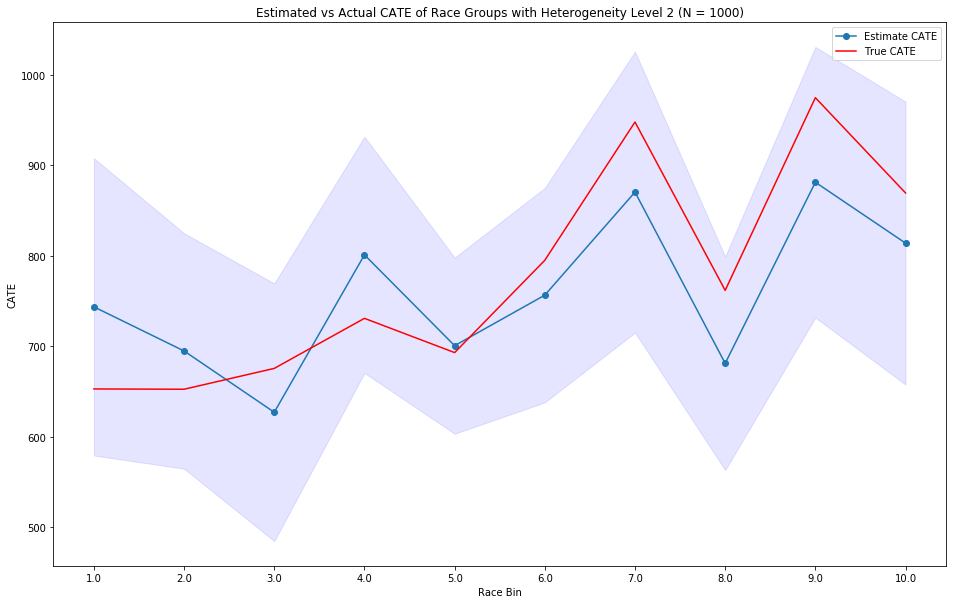

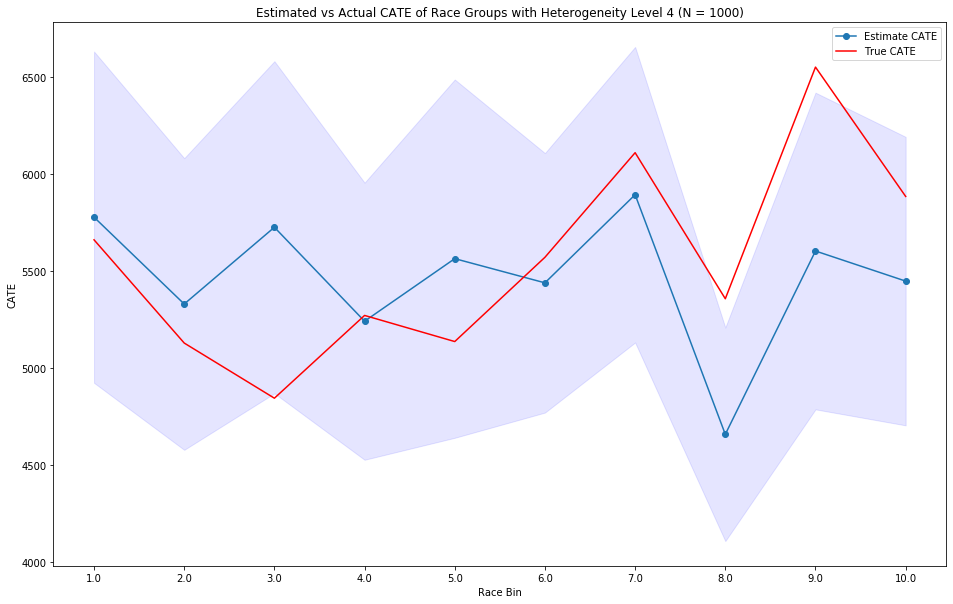

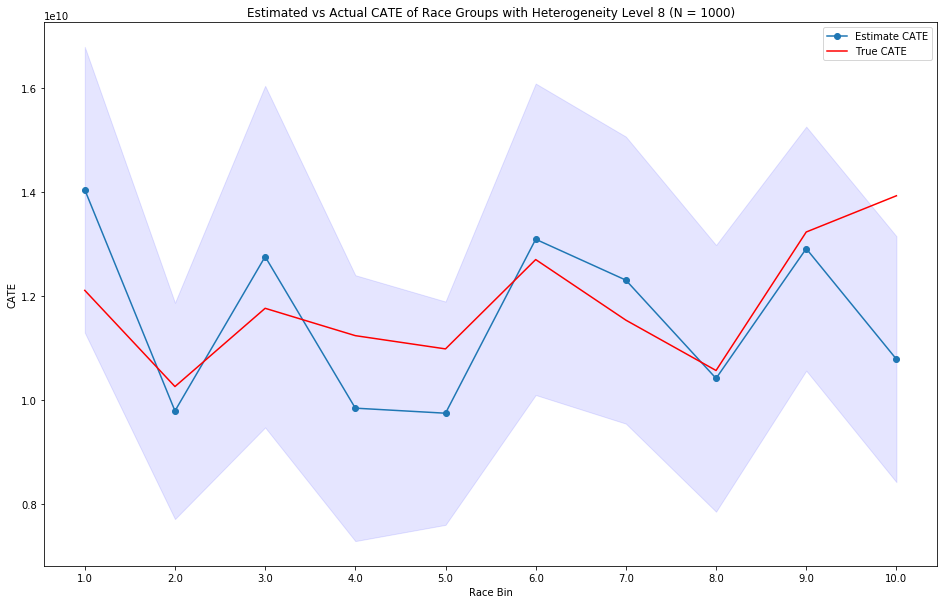

In [155]:
N = 2000
nBins = 10

heterogeneityLevels = [0, 2, 4, 8]

for heterogeneity in tqdm(heterogeneityLevels):

    if heterogeneity == 0:
        y, X, trueBetas, featureNames, treatments, cy, ate, treated, bins, cates = dgp(welfare, effect_type='homogeneous',  N=N, cate_feature='race', nBins=nBins, compute_cate=True)
    else:
        y, X, trueBetas, featureNames, treatments, cy, ate, treated, bins, cates = dgp(welfare, heterogeneous_select=heterogeneity,  N=N, cate_feature='race', nBins=nBins, compute_cate=True)

    yFit, XFit, treatmentsFit, treatedFit, cyFit = y[:N//2], X[:N//2], treatments[:N//2], treated[:N//2], cy[:N//2]

    est, _, _, _, _ = estimate_cf(yFit, XFit, treatmentsFit, treatedFit, cyFit, test_size=0.0)

    # filtering out the bins 
    # so they don’t contain any observations we used to fit the estimator
    binNumbers = np.arange(start=1, stop=1+len(bins))
    filteredBins = []
    for i in range(nBins):
        fBin = []
        for j in range(bins[i].shape[0]):
            if len(np.where((XFit == bins[i][j]).all(axis=1))[0]) == 0:
                fBin.append(bins[i][j])
        filteredBins.append(np.array(fBin))

    cateEstimates = []
    cateLBS = []
    cateUBS = []
    for fBin in filteredBins:
        cate = est.ate(fBin)[0]
        lb, ub = est.ate_interval(fBin, alpha=0.05)
        cateEstimates.append(cate)
        cateLBS.append(lb[0])
        cateUBS.append(ub[0])
    biasRaces = []
    biasRacesNorm = []
    intervalRaces = []
    intervalRacesNorm = []
    coverageRaces = []

    for i in range(nBins):
        bias = abs(cates[i] - cateEstimates[i])
        interval = cateUBS[i] - cateLBS[i]
        coverage = 1 if (cates[i] >= cateLBS[i] and cates[i] <= cateUBS[i]) else 0

        biasRaces.append(bias)
        biasRacesNorm.append(bias/cates[i])
        intervalRaces.append(interval)
        intervalRacesNorm.append(interval/cates[i])
        coverageRaces.append(coverage)

    plt.figure(figsize=(16,10))
    plt.xlabel("Race Bin")
    plt.ylabel("CATE")
    plt.plot(binNumbers, cateEstimates, marker='o', label="Estimate CATE")
    plt.plot(binNumbers, cates, color='red', label='True CATE')
    plt.title("Estimated vs Actual CATE of Race Groups with Heterogeneity Level {} (N = {})".format(heterogeneity, (N//2)))
    plt.legend()
    plt.fill_between(binNumbers, cateLBS, cateUBS, color='b', alpha=.1)
    plt.xticks(np.linspace(start=1, stop=len(bins), num=len(bins)), np.linspace(start=1, stop=len(bins), num=len(bins)))
    plt.show()    
    
    race_data = {'True CATES':cates, 'Estimated CATES':cateEstimates,   
            'Normalized Bias':biasRacesNorm, 'Unnormalized Bias':biasRaces,
            'Normalized Interval Length':intervalRacesNorm, 'Interval Length':intervalRaces, 
            'Coverage':coverageRaces}

    joblib.dump(race_data, 'Results/race_data_{}_{}_h{}.pkl'.format(N, nBins, heterogeneity))

### Educ covariate (not responsible for heterogeneity)

### Baseline DGP

In [127]:
N = 2000
nBins = 10

y, X, trueBetas, featureNames, treatments, cy, ate, treated, bins, cates = dgp(welfare, N=N, cate_feature='educ', nBins=nBins, compute_cate=True)
yFit, XFit, treatmentsFit, treatedFit, cyFit = y[:N//2], X[:N//2], treatments[:N//2], treated[:N//2], cy[:N//2]

est, _, _, _, _ = estimate_cf(yFit, XFit, treatmentsFit, treatedFit, cyFit, test_size=0.0)

binNumbers = np.arange(start=1, stop=1+len(bins))
filteredBins = []
for i in range(nBins):
    fBin = []
    for j in range(bins[i].shape[0]):
        if len(np.where((XFit == bins[i][j]).all(axis=1))[0]) == 0:
            fBin.append(bins[i][j])
    filteredBins.append(np.array(fBin))

cateEstimates = []
cateLBS = []
cateUBS = []
for fBin in filteredBins:
    cate = est.ate(fBin)[0]
    lb, ub = est.ate_interval(fBin, alpha=0.05)
    cateEstimates.append(cate)
    cateLBS.append(lb[0])
    cateUBS.append(ub[0])

In [128]:
biasEducs = []
biasEducsNorm = []
intervalEducs = []
intervalEducsNorm = []
coverageEducs = []

for i in range(nBins):
    bias = cates[i] - cateEstimates[i]
    interval = cateUBS[i] - cateLBS[i]
    coverage = 1 if (cates[i] >= cateLBS[i] and cates[i] <= cateUBS[i]) else 0
    
    biasEducs.append(bias)
    biasEducsNorm.append(bias/cates[i])
    intervalEducs.append(interval)
    intervalEducsNorm.append(interval/cates[i])
    coverageEducs.append(coverage)

educ_data = {'True CATES':cates, 'Estimated CATES':cateEstimates,   
        'Normalized Bias':biasEducsNorm, 'Unnormalized Bias':biasEducs,
        'Normalized Interval Length':intervalEducsNorm, 'Interval Length':intervalEducs, 
        'Coverage':coverageEducs}

In [129]:
joblib.dump(educ_data, 'Results/educ_data_{}_{}.pkl'.format(N, nBins))

['Results/educ_data_2000_10.pkl']

In [90]:
educ_data = joblib.load('Results/educ_data_{}_{}.pkl'.format(N, nBins))

In [112]:
tableEducsCATEs = pd.DataFrame(data=educ_data, index=binNumbers)
tableEducsCATEs

,True CATES,Estimated CATES,Normalized Bias,Unnormalized Bias,Normalized Interval Length,Interval Length,Coverage
1,4124.607404,4046.646484,0.018901,77.960920,0.094164,388.388215,1
2,4559.571007,4618.651526,-0.012957,-59.080519,0.086910,396.270137,1
3,4769.388114,4756.103930,0.002785,13.284184,0.078519,374.488900,1
4,5043.271288,5128.645001,-0.016928,-85.373713,0.082717,417.162414,1
5,5257.320432,5293.118558,-0.006809,-35.798127,0.085870,451.445933,1
6,5508.461255,5430.701776,0.014116,77.759478,0.078716,433.604924,1
7,5655.407995,5548.612654,0.018884,106.795342,0.075317,425.949735,1
8,6049.075987,6167.590230,-0.019592,-118.514244,0.080422,486.476875,1
9,6195.808885,6175.475674,0.003282,20.333212,0.078137,484.123328,1
10,7190.385500,7096.867752,0.013006,93.517747,0.074298,534.233606,1


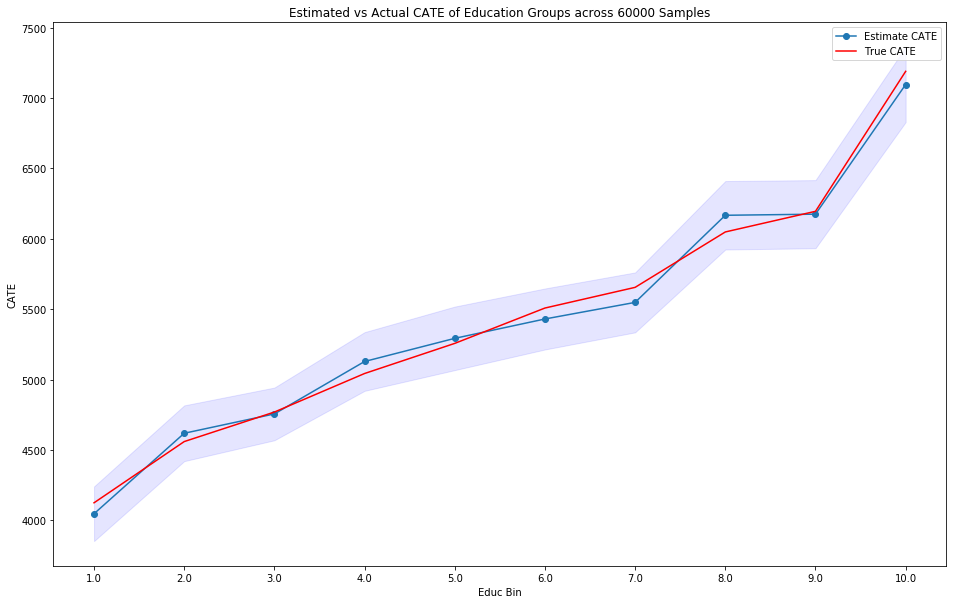

In [115]:
plt.figure(figsize=(16,10))
plt.xlabel("Educ Bin")
plt.ylabel("CATE")
plt.title("Estimated vs Actual CATE of Education Groups across {} Samples".format(N))
plt.plot(binNumbers, cateEstimates, marker='o', label="Estimate CATE")
plt.plot(binNumbers, cates, color='red', label='True CATE')
plt.legend()
plt.fill_between(binNumbers, cateLBS, cateUBS, color='b', alpha=.1)
plt.xticks(np.linspace(start=1, stop=len(bins), num=len(bins)), np.linspace(start=1, stop=len(bins), num=len(bins)))
plt.show()

In [136]:
tableEducsCATEs = pd.DataFrame(data=educ_data, index=binNumbers)
tableEducsCATEs

,True CATES,Estimated CATES,Normalized Bias,Unnormalized Bias,Normalized Interval Length,Interval Length,Coverage
1,4008.051589,4396.320602,-0.096872,-388.269013,0.321414,1288.243497,1
2,4903.381084,4226.946009,0.137953,676.435075,0.277319,1359.802736,1
3,4903.101215,4197.434466,0.143923,705.666749,0.251874,1234.965926,0
4,5120.469566,4394.805763,0.141718,725.663803,0.246160,1260.452777,0
5,4795.588912,4619.913145,0.036633,175.675767,0.246715,1183.145838,1
6,5335.190920,5313.454736,0.004074,21.736183,0.269719,1439.000123,1
7,5300.574686,5446.060638,-0.027447,-145.485952,0.257957,1367.322118,1
8,6519.749205,6276.318752,0.037337,243.430452,0.256746,1673.917805,1
9,6805.388626,6143.575069,0.097248,661.813557,0.219434,1493.331095,1
10,7310.980441,6712.932172,0.081801,598.048269,0.212486,1553.484575,1


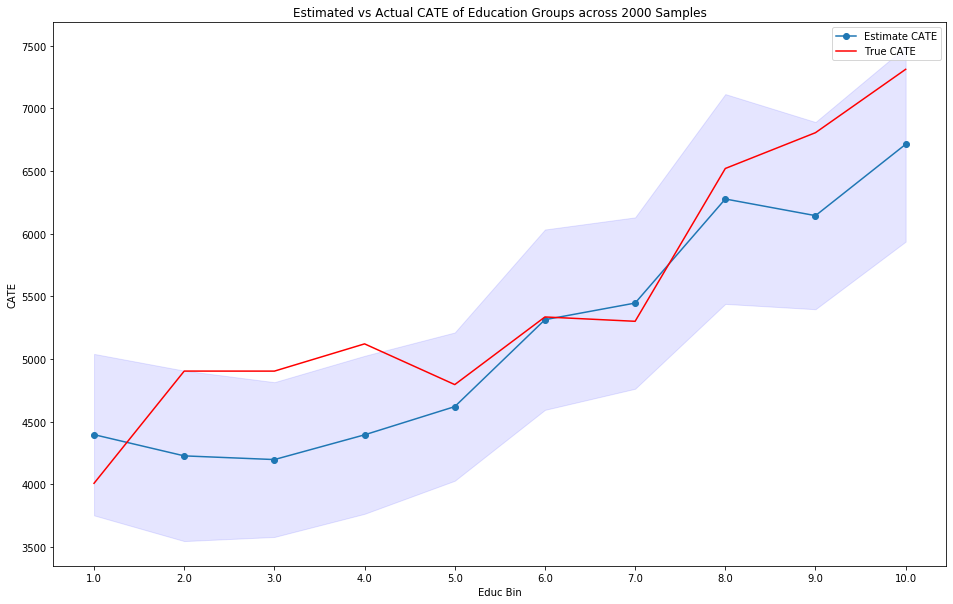

In [130]:
plt.figure(figsize=(16,10))
plt.xlabel("Educ Bin")
plt.ylabel("CATE")
plt.title("Estimated vs Actual CATE of Education Groups across {} Samples".format(N))
plt.plot(binNumbers, cateEstimates, marker='o', label="Estimate CATE")
plt.plot(binNumbers, cates, color='red', label='True CATE')
plt.legend()
plt.fill_between(binNumbers, cateLBS, cateUBS, color='b', alpha=.1)
plt.xticks(np.linspace(start=1, stop=len(bins), num=len(bins)), np.linspace(start=1, stop=len(bins), num=len(bins)))
plt.show()

### Degree of treatment effect heterogeneity

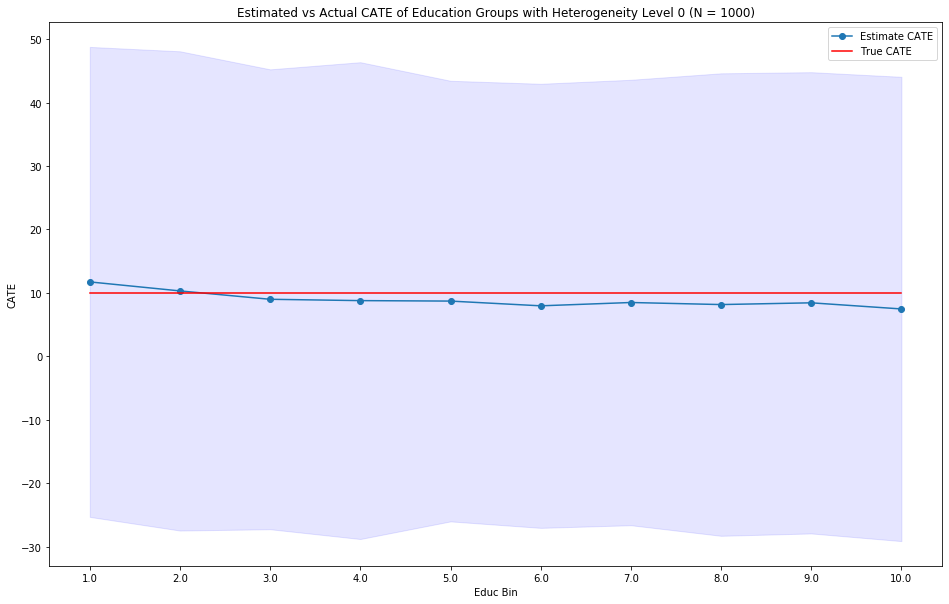

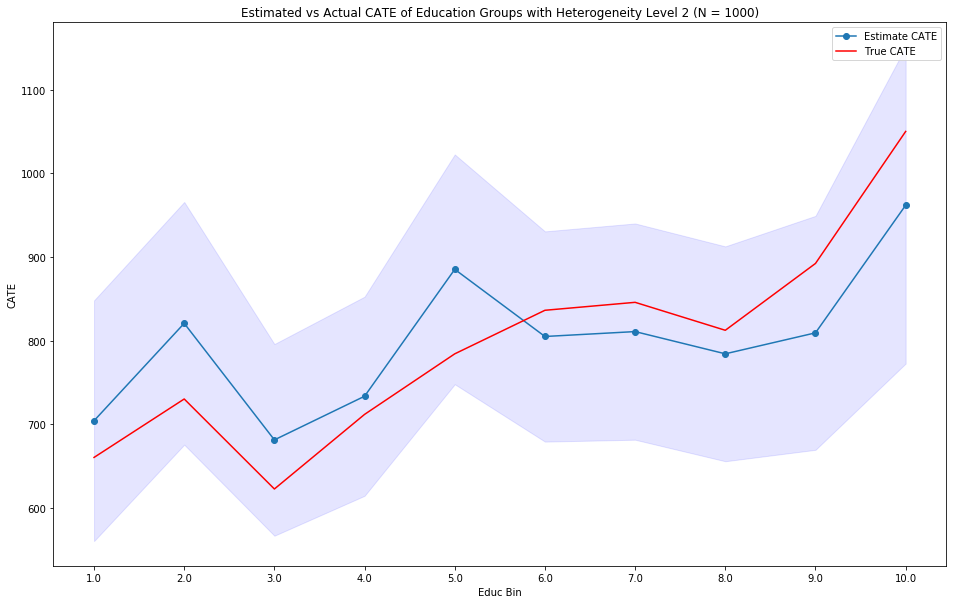

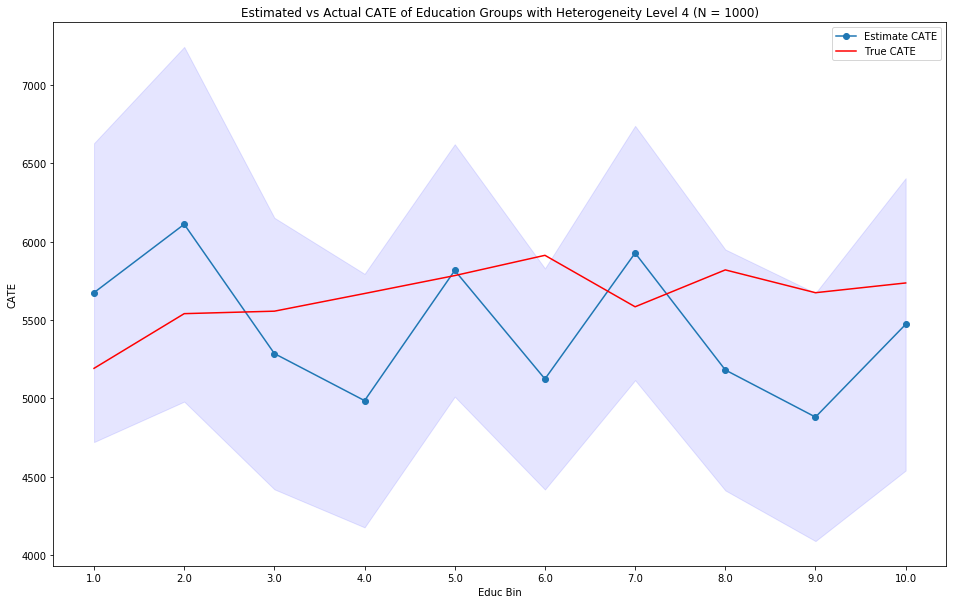

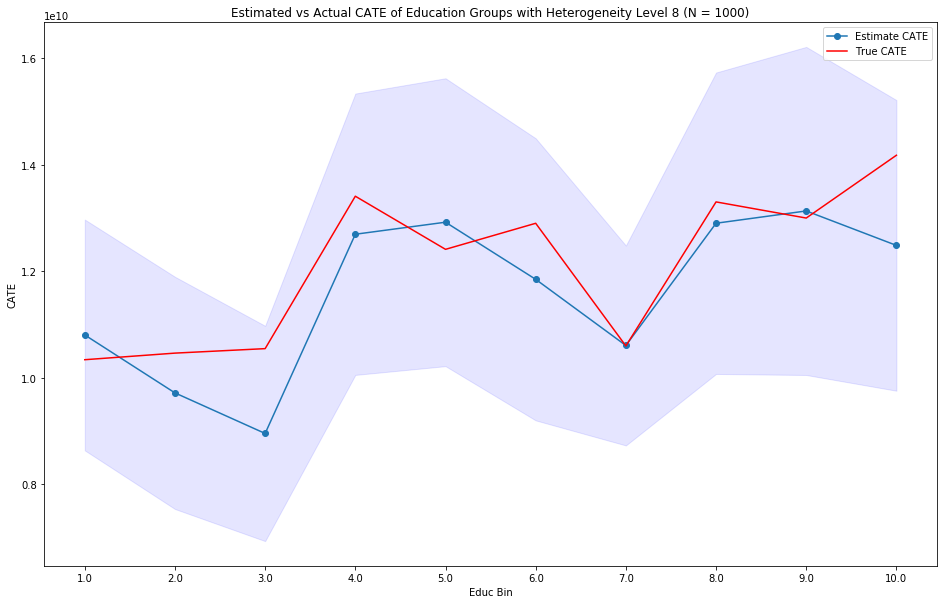

In [157]:
N = 2000
nBins = 10

heterogeneityLevels = [0, 2, 4, 8]

for heterogeneity in tqdm(heterogeneityLevels):

    if heterogeneity == 0:
        y, X, trueBetas, featureNames, treatments, cy, ate, treated, bins, cates = dgp(welfare, effect_type='homogeneous',  N=N, cate_feature='race', nBins=nBins, compute_cate=True)
    else:
        y, X, trueBetas, featureNames, treatments, cy, ate, treated, bins, cates = dgp(welfare, heterogeneous_select=heterogeneity,  N=N, cate_feature='race', nBins=nBins, compute_cate=True)

    yFit, XFit, treatmentsFit, treatedFit, cyFit = y[:N//2], X[:N//2], treatments[:N//2], treated[:N//2], cy[:N//2]

    est, _, _, _, _ = estimate_cf(yFit, XFit, treatmentsFit, treatedFit, cyFit, test_size=0.0)

    # filtering out the bins 
    # so they don’t contain any observations we used to fit the estimator
    binNumbers = np.arange(start=1, stop=1+len(bins))
    filteredBins = []
    for i in range(nBins):
        fBin = []
        for j in range(bins[i].shape[0]):
            if len(np.where((XFit == bins[i][j]).all(axis=1))[0]) == 0:
                fBin.append(bins[i][j])
        filteredBins.append(np.array(fBin))

    cateEstimates = []
    cateLBS = []
    cateUBS = []
    for fBin in filteredBins:
        cate = est.ate(fBin)[0]
        lb, ub = est.ate_interval(fBin, alpha=0.05)
        cateEstimates.append(cate)
        cateLBS.append(lb[0])
        cateUBS.append(ub[0])
    biasEducs = []
    biasEducsNorm = []
    intervalEducs = []
    intervalEducsNorm = []
    coverageEducs = []

    for i in range(nBins):
        bias = cates[i] - cateEstimates[i]
        interval = cateUBS[i] - cateLBS[i]
        coverage = 1 if (cates[i] >= cateLBS[i] and cates[i] <= cateUBS[i]) else 0

        biasEducs.append(bias)
        biasEducsNorm.append(bias/cates[i])
        intervalEducs.append(interval)
        intervalEducsNorm.append(interval/cates[i])
        coverageEducs.append(coverage)

    educ_data = {'True CATES':cates, 'Estimated CATES':cateEstimates,   
            'Normalized Bias':biasEducsNorm, 'Unnormalized Bias':biasEducs,
            'Normalized Interval Length':intervalEducsNorm, 'Interval Length':intervalEducs, 
            'Coverage':coverageEducs}
    
    plt.figure(figsize=(16,10))
    plt.xlabel("Educ Bin")
    plt.ylabel("CATE")
    plt.plot(binNumbers, cateEstimates, marker='o', label="Estimate CATE")
    plt.plot(binNumbers, cates, color='red', label='True CATE')
    plt.legend()
    plt.fill_between(binNumbers, cateLBS, cateUBS, color='b', alpha=.1)
    plt.title("Estimated vs Actual CATE of Education Groups with Heterogeneity Level {} (N = {})".format(heterogeneity, (N//2)))
    plt.xticks(np.linspace(start=1, stop=len(bins), num=len(bins)), np.linspace(start=1, stop=len(bins), num=len(bins)))
    plt.show()

    joblib.dump(educ_data, 'Results/educ_data_{}_{}_h{}.pkl'.format(N, nBins, heterogeneity))